In [1]:
#Libraries
from math import floor, exp, sqrt, pi
import cmath
import numpy
from numpy import e, cos, zeros, arange, roll, where, random, ones, mean, reshape, dot, array, flipud, pi, exp, dot, angle, degrees, shape, linspace
import matplotlib.pyplot as plt
from itertools import chain
import scipy
from scipy import special
import numpy as np 
import seaborn as sns


In [352]:
#Parameters

totalTime=2000;
dt=2;
nsteps=int(floor(totalTime/dt));
num_cicles=10;

    
N=512;
origin = pi

#temporal variable (largerT means smaller firing rate)
tauE=  9; 
tauI=  4; 

#Conductances (larger G means larger firing rate). Diff cond. for connections
GEE=  0.041    ###0.021
GEI=  0.06 ###0.020 
GIE=  0.01 ###0.01  
GII=  0.01
I0E=  0.07##0.2; (as it decreases --> less bumps)
I0I=  0.7##0.5; (as it increases --> less bumps)

#Realted with noise
sigE=  1.5 #1.5 #1 #0.5 ;
sigI=  1.6 #1.6 #2 #1.3 ;

#Stimulus (when on and off, separation between them and strenght)
targ_onset = 100;
targ_offset = 500;
dist_onset = 900;
dist_offset = 1200;

n_stims=2; #2
stim_sep = pi/6 ###13 --> 2   (13 attract, 9 solo 1, 5 repulsion, 2 nada)
#stim_sep=0

kappa_stim= 100

kappa_E=  200  #100          original#600
kappa_I=   100 #2.75 #1.75 -2 .75#####3   #3    ###############0.5 - 5     original#5


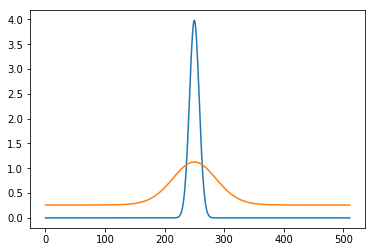

In [353]:
#Connectivities

kappa_E=  100  # 100  1/k in vaon misses is std    ( https://en.wikipedia.org/wiki/Von_Mises_distribution) 
kappa_I= 5 # 2.75  


v_E=zeros((N));
v_I=zeros((N));
WE=zeros((N,N));
WI=zeros((N,N));


theta = [float(range(0,N)[i])/N*2*pi for i in range(0,N)] 

for i in range(0, N):
    v_E_new=[e**(kappa_E*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_E)) for f in range(0, len(theta))]    
    v_I_new=[e**(kappa_I*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_I)) +0.26 for f in range(0, len(theta))]
    ###    
    vE_NEW=roll(v_E_new,i)
    vI_NEW=roll(v_I_new,i) #to roll
    ###    
    WE[:,i]=vE_NEW
    WI[:,i]=vI_NEW

    
    
    
plt.plot(WE[250, :])
plt.plot(WI[250, :])
plt.show(block=False)


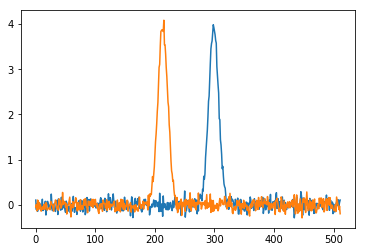

In [354]:
# stims
target=zeros((N))
distractor=zeros((N))

for i in range(0, N):
    target[i]=e**(kappa_stim*cos(theta[i] + origin - stim_sep)) / (2*pi*scipy.special.i0(kappa_stim)) 
    distractor[i]=e**(kappa_stim*cos(theta[i] + origin + stim_sep)) / (2*pi*scipy.special.i0(kappa_stim)) 


target = target+ np.random.normal(0, 0.1, N)
target=reshape(target, (N,1)) 


distractor = distractor+ np.random.normal(0, 0.1, N)
distractor=reshape(distractor, (N,1)) 

    
######################

targon = floor(targ_onset/dt);
targoff = floor(targ_offset/dt);

diston = floor(dist_onset/dt);
distoff = floor(dist_offset/dt);

plt.plot(target)
plt.plot(distractor)
plt.show(block=False)

In [355]:
#Simulation

rE=zeros((N,1));
rI=zeros((N,1)); 

#generation of the noise and the connectivity between inhib and exit
RE=zeros((N,nsteps));
RI=zeros((N,nsteps));


f = lambda x : x*x*(x>0)*(x<1) + reshape(array([cmath.sqrt(4*x[i]-3) for i in range(0, len(x))]).real, (N,1)) * (x>=1)


### diferential equations
for i in range(0, nsteps):
    noiseE = sigE*random.randn(N,1);
    noiseI = sigI*random.randn(N,1);
    
    #differential equations for connectivity
    IE= GEE*dot(WE,rE) - GIE*dot(WI,rI) + I0E*ones((N,1)); #Antes el primer término era: GEE*WE*rE ahora solo esta WE_GEE ya que hay una GEE para cada distancia
    II= GEI*dot(WE,rE) +  (I0I-GII*mean(rI))*ones((N,1));
    
    if i>targon and i<targoff:
        IE=IE+target;
        II=II+target;
    
    if i>diston and i<distoff:
        IE=IE+distractor;
        II=II+distractor;
    
    
    #rates of exit and inhib
    rE = rE + (f(IE) - rE + noiseE)*dt/tauE;
    rI = rI + (f(II) - rI + noiseI)*dt/tauI;
    
    rEr=reshape(rE, N)
    rIr=reshape(rI, N)
    #drawnow
    RE[:,i] = rEr;
    RI[:,i] = rIr;
    






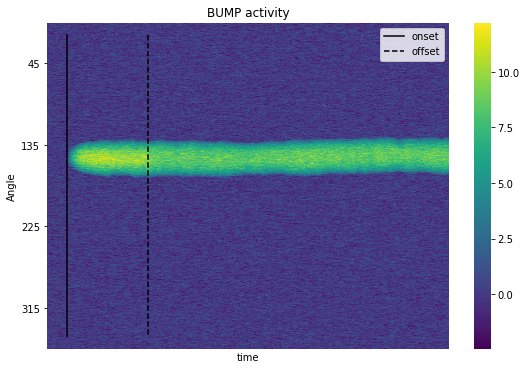

In [356]:
### Plot of activity
RE_sorted=flipud(RE)
plt.figure(figsize=(9,6))
sns.heatmap(RE_sorted, cmap='viridis')
plt.title('BUMP activity')
plt.ylabel('Angle')
plt.xlabel('time')
plt.yticks([])
plt.xticks([])

plt.yticks([N/8, 3*N/8, 5*N/8, 7*N/8 ] ,['45','135','225', '315'])

plt.plot([targ_onset/2, targ_onset/2,], [0+20, N-20], 'k-', label='onset')
plt.plot([targ_offset/2, targ_offset/2,], [0+20, N-20], 'k--', label='offset')

plt.legend()
plt.show(block=False)